# COMP47590: Advanced Machine Learning
## Project 1: RoboRacer

Autonomously driven vehicles have been long-promised , but are finally becoming a reality. This assignment will train a model to control a self-driving car.

- Student 1 Name: Chungman Lee
- Student 1 Number: 23205535

### Import Packages

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transforms

import wand

from xy_dataset import XYDataset # A custom file that implements simple data processing.

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import wandb

from torchvision.transforms import ToPILImage

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

from torchvision import models

### Dataset Setup

Setup the dataset - using custom dataset opbject.

In [2]:
ROOT_DIR = './'
TASK = 'robo_racer_dev'

If using Google Colab use the code below.

In [3]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#import sys
#sys.path.append('/content/drive/MyDrive/COMP47590_Labs/Lab5_JetRacer')
#ROOT_DIR = '/content/drive/MyDrive/COMP47590_Labs/Lab5_JetRacer/'

In [4]:
TRAINING_SPLIT_SIZE = 0.8
BATCH_SIZE = 32

TRANSFORMS = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor()
                                ])

dataset = XYDataset(ROOT_DIR + TASK, TRANSFORMS)

n_samples = len(dataset)

print("Dataset length: ", n_samples)

Dataset length:  1192


### Partition Dataset

Partition the datset into training and valudation partitons using PyTorch data loaders. 

In [5]:
n_train = int(n_samples*TRAINING_SPLIT_SIZE)
n_val = n_samples - n_train

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

print("Training dataset length: ", len(train_dataset))
print("Validation dataset length: ", len(val_dataset))

# Create Dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
# Create Dataloader
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Training dataset length:  953
Validation dataset length:  239


### Task 1: View Sample Images

Training Dataset Sample Images:


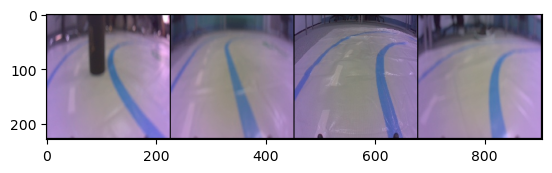

Labels: tensor([[-0.6429,  0.0446],
        [-0.2679, -0.0804],
        [ 0.0804, -0.0268],
        [-0.1607, -0.0179]])
Validation Dataset Sample Images:


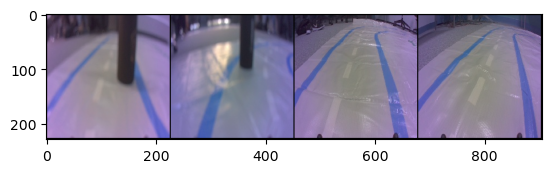

Labels: tensor([[-0.1696, -0.1250],
        [ 0.5982,  0.2232],
        [ 0.1429, -0.1071],
        [ 0.3661, -0.0536]])


In [6]:
# visualize image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# visualize the sample images from Datloader
def show_sample_images(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images[:4]))

    print('Labels:', labels[:4])

print("Training Dataset Sample Images:")
show_sample_images(train_dataloader)

print("Validation Dataset Sample Images:")
show_sample_images(val_dataloader)

### Task 2: Simple CNN

#### Task 2-1 Set up the convolutional neural network

In [7]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Adjust in_channels based on your input image channels (e.g., 3 for RGB images)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Input images are 224x224, after two pooling layers the size is 224/2/2 = 56
        self.fc1 = nn.Linear(in_features=64 * 56 * 56, out_features=128)
        
        # Output layer for the X and Y coordinates
        self.fc2 = nn.Linear(in_features=128, out_features=2) # 2 for X and Y coordinates

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        
        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = CNN()

print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


#### Task 2-2. Train the model

wandb logging

In [8]:
wandb.login()

wandb: Currently logged in as: 51150076a. Use `wandb login --relogin` to force relogin


True

In [9]:
# Initialize Weights & Biases project
wandb.init(
    project="robo_racer_project",
    name = "simple_CNN",
        config={
            "epochs": 25,
            "batch_size": BATCH_SIZE,
            "lr": 1e-3
            })
config = wandb.config

Define a function for training the model

In [10]:
def train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, config):
    """
    Train and validate the model.

    Parameters:
    - model: The neural network model to train.
    - train_dataloader: DataLoader for the training data.
    - val_dataloader: DataLoader for the validation data.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - config: Configuration object containing parameters like epochs, etc.

    Returns:
    - train_losses: List of training loss values per epoch.
    - val_losses: List of validation loss values per epoch.
    """
    train_losses = []
    val_losses = []

    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)
        
        # Calculate loss on validation set
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item() * inputs.size(0)
        
        val_epoch_loss = val_running_loss / len(val_dataloader.dataset)
        val_losses.append(val_epoch_loss)
        
        # Log training and validation loss to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": epoch_loss,
            "val_loss": val_epoch_loss,
        })
        
        print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
    
    return train_losses, val_losses

In [11]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# Train the model
train_losses, val_losses = train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, config)

Epoch 1/25, Train Loss: 2.7155, Val Loss: 0.0735
Epoch 2/25, Train Loss: 0.0719, Val Loss: 0.0681
Epoch 3/25, Train Loss: 0.0663, Val Loss: 0.0615
Epoch 4/25, Train Loss: 0.0548, Val Loss: 0.0485
Epoch 5/25, Train Loss: 0.0350, Val Loss: 0.0350
Epoch 6/25, Train Loss: 0.0285, Val Loss: 0.0286
Epoch 7/25, Train Loss: 0.0236, Val Loss: 0.0244
Epoch 8/25, Train Loss: 0.0195, Val Loss: 0.0223
Epoch 9/25, Train Loss: 0.0192, Val Loss: 0.0212
Epoch 10/25, Train Loss: 0.0155, Val Loss: 0.0199
Epoch 11/25, Train Loss: 0.0153, Val Loss: 0.0232
Epoch 12/25, Train Loss: 0.0143, Val Loss: 0.0222
Epoch 13/25, Train Loss: 0.0132, Val Loss: 0.0198
Epoch 14/25, Train Loss: 0.0125, Val Loss: 0.0192
Epoch 15/25, Train Loss: 0.0116, Val Loss: 0.0206
Epoch 16/25, Train Loss: 0.0114, Val Loss: 0.0206
Epoch 17/25, Train Loss: 0.0110, Val Loss: 0.0212
Epoch 18/25, Train Loss: 0.0108, Val Loss: 0.0197
Epoch 19/25, Train Loss: 0.0104, Val Loss: 0.0214
Epoch 20/25, Train Loss: 0.0099, Val Loss: 0.0221
Epoch 21/

Plot loss the training and validation loss history.

In [12]:
def plot_loss_history(train_losses, val_losses):
    """
    Parameters:
    - train_losses: List of training loss values per epoch.
    - val_losses: List of validation loss values per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

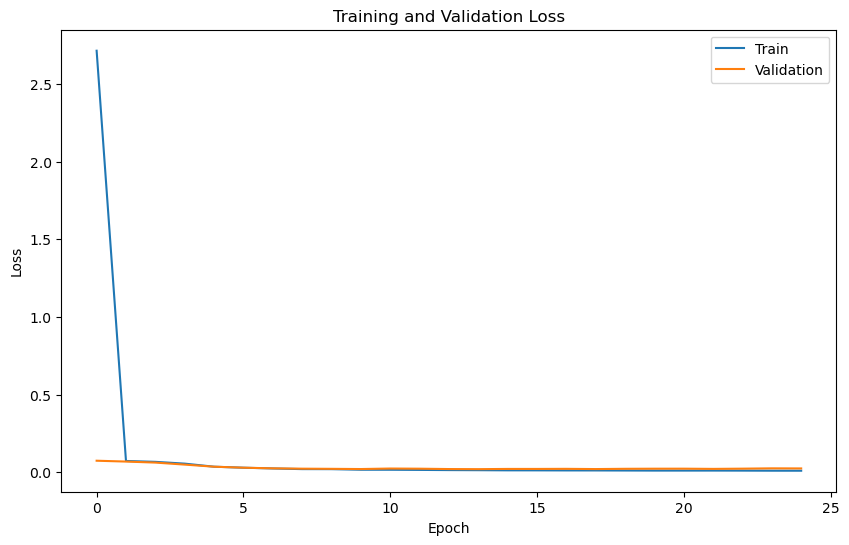

In [13]:
plot_loss_history(train_losses, val_losses)

Visualize from epoch 2 to see the difference properly

In [14]:
def plot_loss_history_2(train_losses, val_losses):
    """
    Parameters:
    - train_losses: List of training loss values per epoch.
    - val_losses: List of validation loss values per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, len(train_losses)+1), train_losses[1:], label='Train')
    plt.plot(range(2, len(val_losses)+1), val_losses[1:], label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

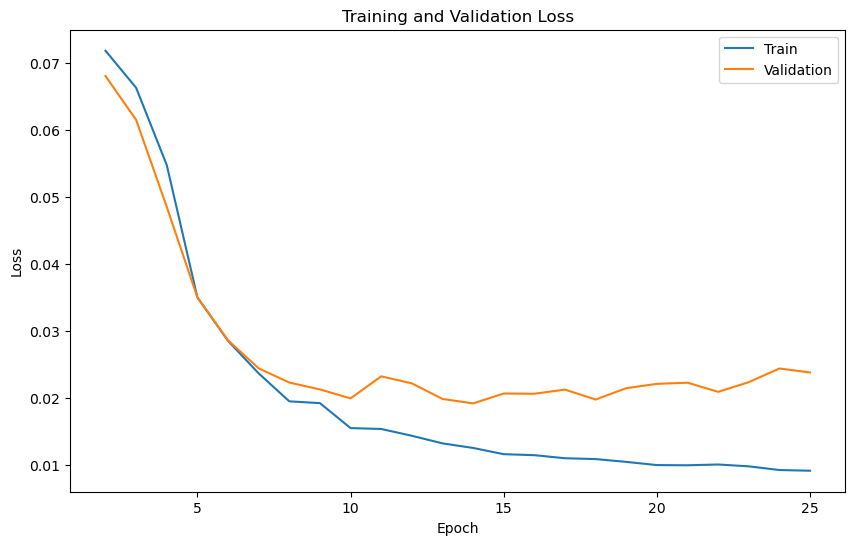

In [15]:
plot_loss_history_2(train_losses, val_losses)

#### Task 2-3. Evaluate CNN

In [16]:
def evaluate_model(model, dataloader, criterion):
    """
    Evaluate the model on a given dataloader and log metrics using Weights & Biases.

    Parameters:
    - model: The neural network model to evaluate.
    - dataloader: DataLoader for the data to evaluate the model on.
    - criterion: Loss function used for evaluation.
    
    Returns:
    - A dictionary containing validation loss, MSE, RMSE, and MAE.
    """
    model.eval()
    running_loss = 0.0
    actuals = []
    predictions = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            # Assuming the model and data are on the same device, if not, move them to the same device.
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays for further analysis
    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Calculate metrics
    val_loss = running_loss / len(dataloader.dataset)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    # Log metrics using Weights & Biases
    wandb.log({
        "val_loss": val_loss,
        "val_mse": mse,
        "val_rmse": rmse,
        "val_mae": mae,
    })

    print(f'Validation Loss: {val_loss:.4f}, Validation MSE: {mse:.4f}, Validation RMSE: {rmse:.4f}, Validation MAE: {mae:.4f}')

    return {
        "val_loss": val_loss,
        "val_mse": mse,
        "val_rmse": rmse,
        "val_mae": mae,
        "actuals": actuals,
        "predictions": predictions
    }

In [17]:
evaluation_metrics = evaluate_model(model, val_dataloader, criterion)

Validation Loss: 0.0238, Validation MSE: 0.0238, Validation RMSE: 0.1542, Validation MAE: 0.1107


Visualize the result

In [18]:
# Plot actual vs predicted values
def plot_actual_vs_predicted(actuals, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r')  # Plot a diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.show()

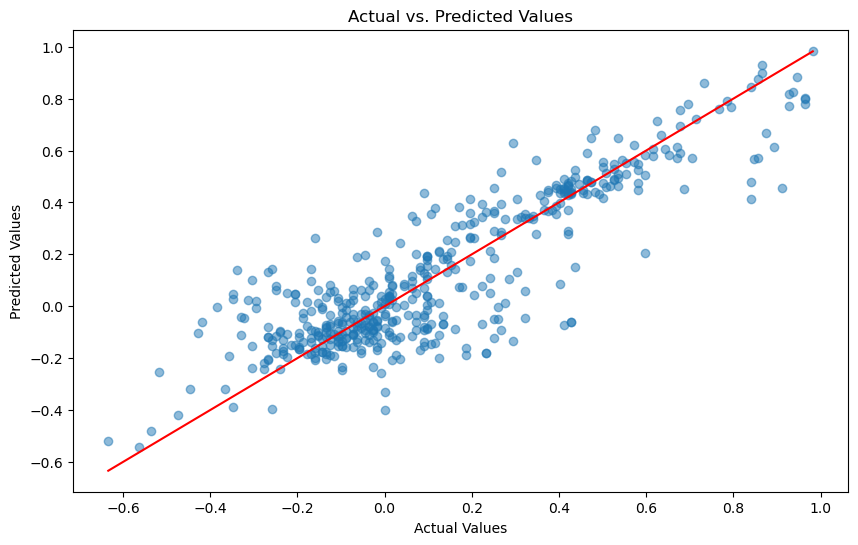

In [19]:
actuals = evaluation_metrics["actuals"]
predictions = evaluation_metrics["predictions"]
plot_actual_vs_predicted(actuals, predictions)

In [20]:
# Plot prediction error distribution
def plot_error_distribution(actuals, predictions):
    errors = predictions - actuals
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=20, alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Prediction Error Distribution')
    plt.show()

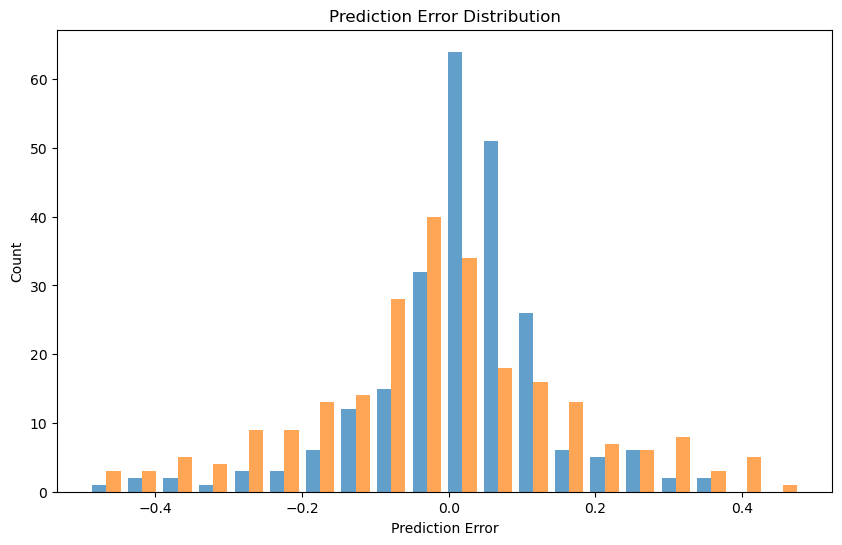

In [21]:
plot_error_distribution(actuals, predictions)

In [22]:
# Plot residuals vs. actual values
def plot_residual_vs_actual(actuals, predictions):
    errors = predictions - actuals
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Actual Values')
    plt.show()

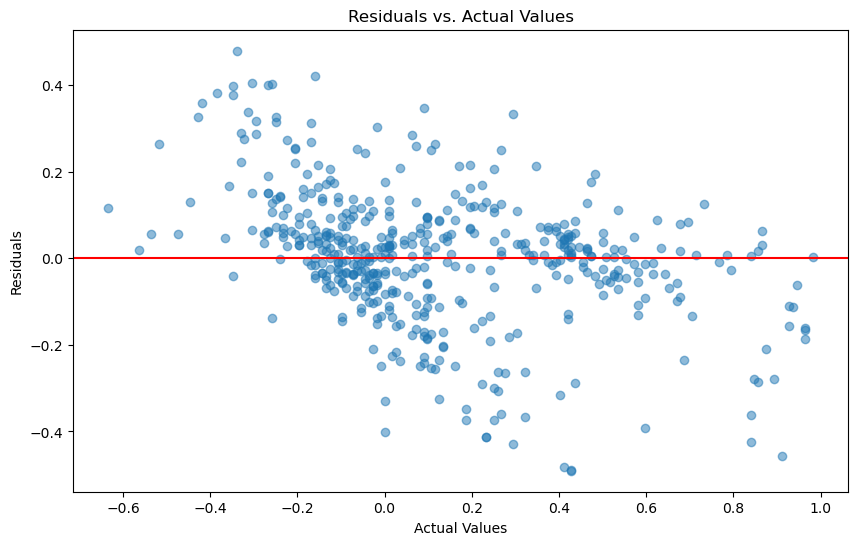

In [23]:
plot_residual_vs_actual(actuals, predictions)

In [24]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
val_mae,▁
val_mse,▁
val_rmse,▁
epoch,25
train_loss,0.0091
val_loss,0.02378
val_mae,0.11071
val_mse,0.02378


### Task 3: Transfer Learning

#### Task 3-1 Set up the transferCNN

In [25]:
class TransferCNN(nn.Module):
    def __init__(self, num_output_features=2):  # num_output_features = X and Y coordinates
        super(TransferCNN, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze all layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Replace the final fully connected layer
        # ResNet18's fc layer input features
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_output_features)
        
    def forward(self, x):
        # Forward pass through the modified ResNet model
        x = self.resnet(x)
        return x

# Create an instance of the model
model = TransferCNN()

print(model)

TransferCNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Task 3-2. Train the transfer CNN

Initialize Weights & Biases project

In [26]:
wandb.init(project="robo_racer_project", name="transfer_CNN", config={
    "epochs": 25,
    "batch_size": BATCH_SIZE,
    "lr": 1e-3
})
config = wandb.config

Train the model

In [27]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# Train the model
train_losses, val_losses = train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, config)

Epoch 1/25, Train Loss: 0.1727, Val Loss: 0.1324
Epoch 2/25, Train Loss: 0.1068, Val Loss: 0.0757
Epoch 3/25, Train Loss: 0.0822, Val Loss: 0.0648
Epoch 4/25, Train Loss: 0.0724, Val Loss: 0.0573
Epoch 5/25, Train Loss: 0.0643, Val Loss: 0.0567
Epoch 6/25, Train Loss: 0.0624, Val Loss: 0.0468
Epoch 7/25, Train Loss: 0.0495, Val Loss: 0.0603
Epoch 8/25, Train Loss: 0.0473, Val Loss: 0.0412
Epoch 9/25, Train Loss: 0.0482, Val Loss: 0.0405
Epoch 10/25, Train Loss: 0.0441, Val Loss: 0.0405
Epoch 11/25, Train Loss: 0.0420, Val Loss: 0.0378
Epoch 12/25, Train Loss: 0.0385, Val Loss: 0.0397
Epoch 13/25, Train Loss: 0.0379, Val Loss: 0.0372
Epoch 14/25, Train Loss: 0.0387, Val Loss: 0.0367
Epoch 15/25, Train Loss: 0.0353, Val Loss: 0.0383
Epoch 16/25, Train Loss: 0.0367, Val Loss: 0.0446
Epoch 17/25, Train Loss: 0.0367, Val Loss: 0.0410
Epoch 18/25, Train Loss: 0.0381, Val Loss: 0.0436
Epoch 19/25, Train Loss: 0.0352, Val Loss: 0.0351
Epoch 20/25, Train Loss: 0.0341, Val Loss: 0.0391
Epoch 21/

Summarize history for loss

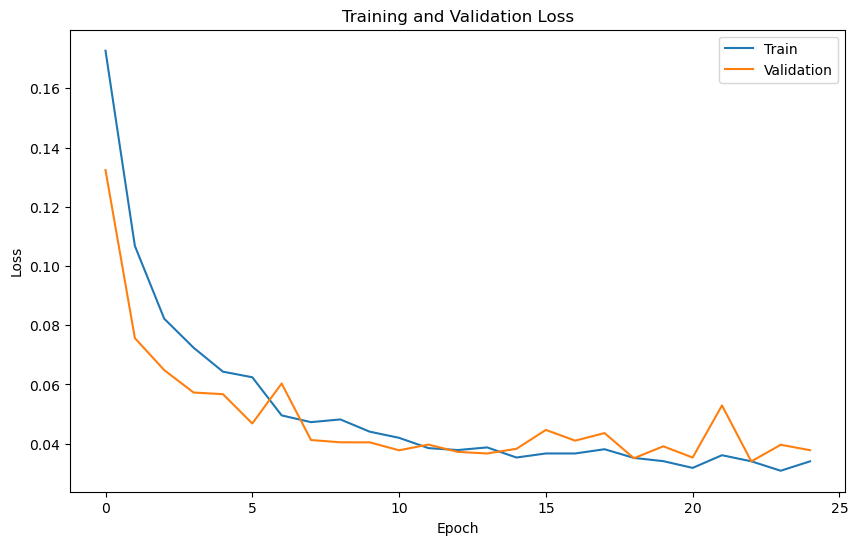

In [28]:
plot_loss_history(train_losses, val_losses)

#### Task 3-3. Evaluate the transfer CNN

In [29]:
evaluation_metrics = evaluate_model(model, val_dataloader, criterion)

Validation Loss: 0.0378, Validation MSE: 0.0378, Validation RMSE: 0.1944, Validation MAE: 0.1497


Visualize the result

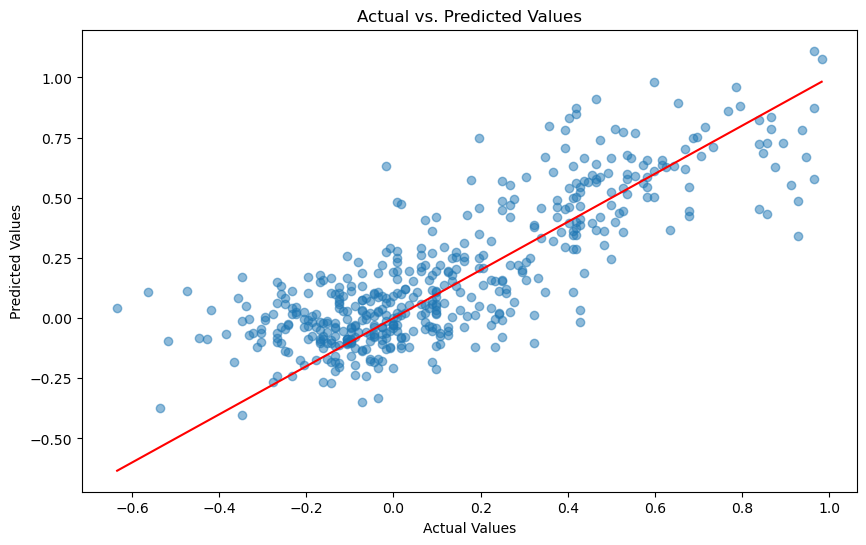

In [30]:
actuals = evaluation_metrics["actuals"]
predictions = evaluation_metrics["predictions"]
plot_actual_vs_predicted(actuals, predictions)

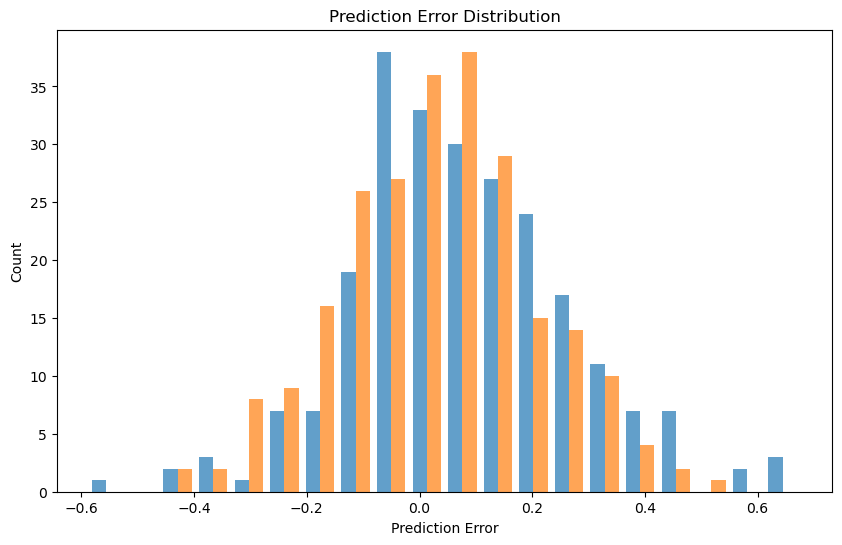

In [31]:
plot_error_distribution(actuals, predictions)

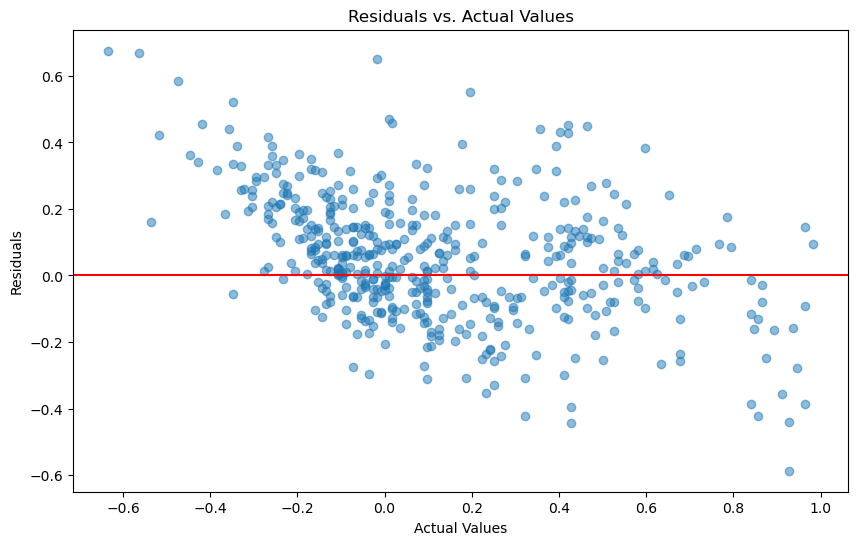

In [32]:
plot_residual_vs_actual(actuals, predictions)

In [33]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▃▂▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁
val_mae,▁
val_mse,▁
val_rmse,▁
epoch,25
train_loss,0.03404
val_loss,0.0378
val_mae,0.14974
val_mse,0.0378


### Task 4: Data Augmentation

According to the result of the evaluation, simple CNN is better because its all elements (Loss/MSE, MAE, RMSE) are lower than transfer learning one

Add data augmentation to the simple CNN

#### Task 4-1 Define the data transformations

In [34]:
train_transforms_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

Partition the data in train, validation, and test partitions.

Apply argumentation

In [35]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset 
        self.transform = transform
        self.to_pil = ToPILImage()

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, index):
        x, y = self.subset[index]
        if isinstance(x, torch.Tensor):
            x = self.to_pil(x)
        if self.transform:
            x = self.transform(x)
        return x, y

In [36]:
train_dataset_aug = CustomDataset(train_dataset, transform=train_transforms_aug)

Create data loader

In [37]:
train_dataloader_aug = torch.utils.data.DataLoader(
    train_dataset_aug,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Check sample images

Training Dataset Sample Images:


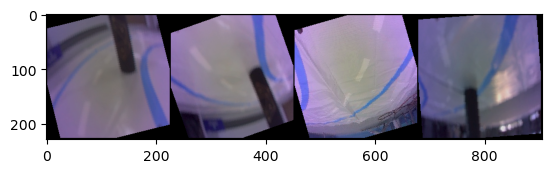

Labels: tensor([[-0.0982, -0.1429],
        [-0.0536, -0.1964],
        [ 0.5179, -0.1161],
        [ 0.6875, -0.2321]])
Validation Dataset Sample Images:


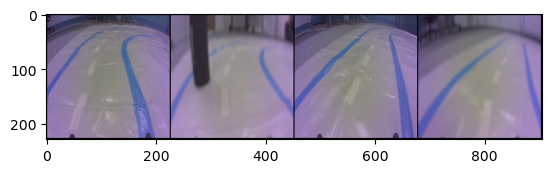

Labels: tensor([[ 0.0089, -0.2500],
        [ 0.1518, -0.2679],
        [ 0.3661, -0.0536],
        [ 0.5357,  0.0982]])


In [38]:
print("Training Dataset Sample Images:")
show_sample_images(train_dataloader_aug)
print("Validation Dataset Sample Images:")
show_sample_images(val_dataloader)

#### Task 4-2. Train the CNN with augmentation

Set model before initialize wandb

Initialize Weights & Biases project

In [39]:
wandb.init(
    project="robo_racer_project",
    name = "simple_CNN_aug",
        config={
            "epochs": 25,
            "batch_size": BATCH_SIZE,
            "lr": 1e-3
            })
config = wandb.config

In [40]:
# Define the loss function and optimizer
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

In [41]:
# Train the model
train_losses, val_losses = train_and_validate(model, train_dataloader_aug, val_dataloader, criterion, optimizer, config)

Epoch 1/25, Train Loss: 4.6189, Val Loss: 0.0716
Epoch 2/25, Train Loss: 0.0739, Val Loss: 0.0721
Epoch 3/25, Train Loss: 0.0727, Val Loss: 0.0728
Epoch 4/25, Train Loss: 0.0712, Val Loss: 0.0722
Epoch 5/25, Train Loss: 0.0709, Val Loss: 0.0683
Epoch 6/25, Train Loss: 0.0683, Val Loss: 0.0737
Epoch 7/25, Train Loss: 0.0674, Val Loss: 0.0610
Epoch 8/25, Train Loss: 0.0627, Val Loss: 0.0639
Epoch 9/25, Train Loss: 0.0596, Val Loss: 0.0613
Epoch 10/25, Train Loss: 0.0626, Val Loss: 0.0589
Epoch 11/25, Train Loss: 0.0589, Val Loss: 0.0546
Epoch 12/25, Train Loss: 0.0565, Val Loss: 0.0533
Epoch 13/25, Train Loss: 0.0540, Val Loss: 0.0472
Epoch 14/25, Train Loss: 0.0537, Val Loss: 0.0480
Epoch 15/25, Train Loss: 0.0509, Val Loss: 0.0473
Epoch 16/25, Train Loss: 0.0504, Val Loss: 0.0491
Epoch 17/25, Train Loss: 0.0478, Val Loss: 0.0464
Epoch 18/25, Train Loss: 0.0473, Val Loss: 0.0466
Epoch 19/25, Train Loss: 0.0465, Val Loss: 0.0501
Epoch 20/25, Train Loss: 0.0501, Val Loss: 0.0514
Epoch 21/

Summarize history for loss

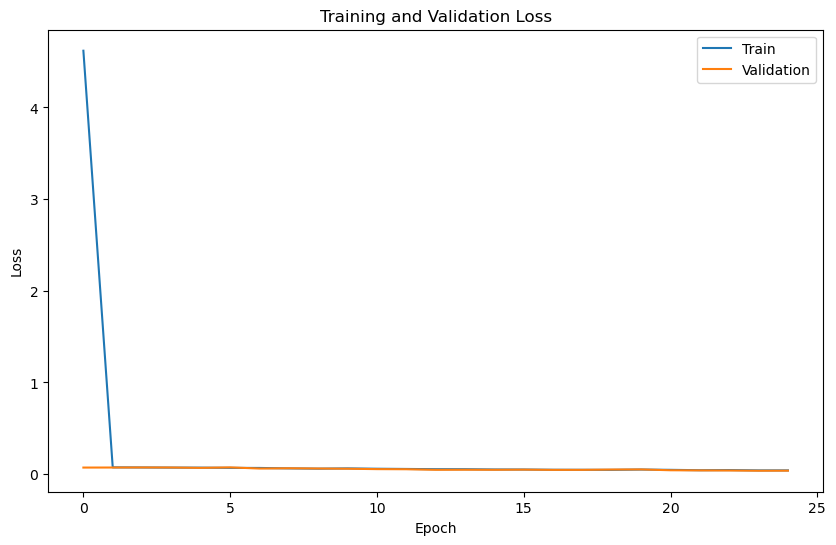

In [42]:
plot_loss_history(train_losses, val_losses)

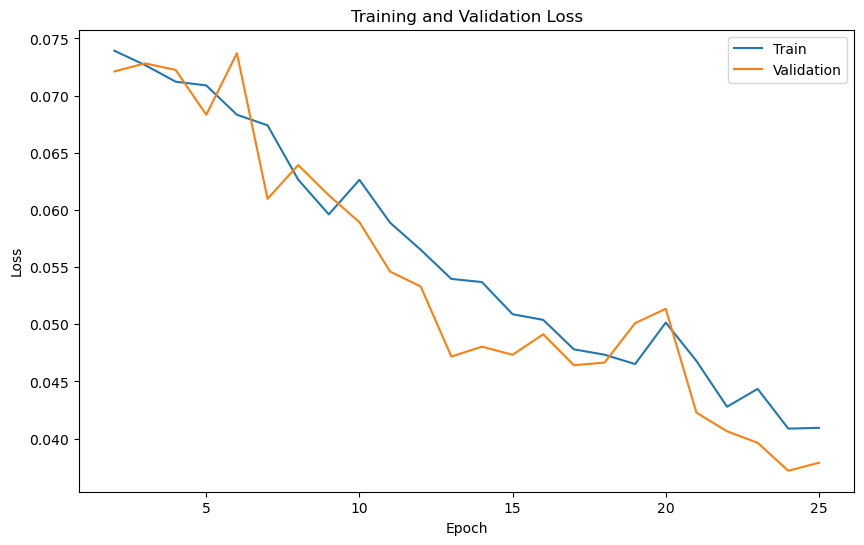

In [43]:
plot_loss_history_2(train_losses, val_losses)

#### Task 4-3. Evaluate CNN with augmentation

In [44]:
evaluation_metrics = evaluate_model(model, val_dataloader, criterion)

Validation Loss: 0.0379, Validation MSE: 0.0379, Validation RMSE: 0.1946, Validation MAE: 0.1387


Visualize the result

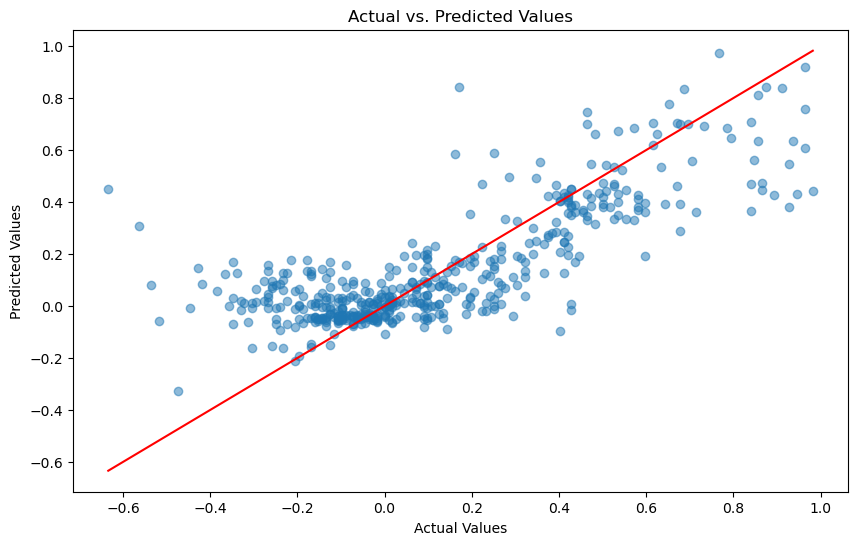

In [45]:
actuals = evaluation_metrics["actuals"]
predictions = evaluation_metrics["predictions"]
plot_actual_vs_predicted(actuals, predictions)

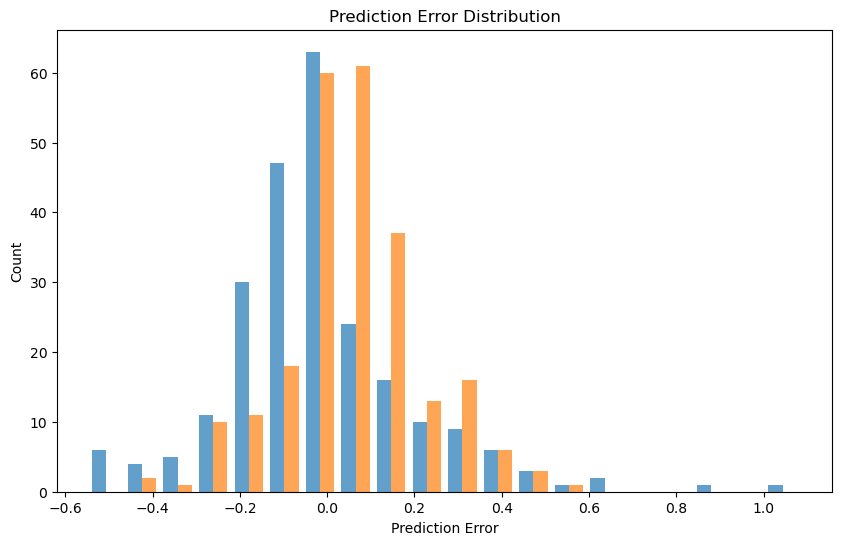

In [46]:
plot_error_distribution(actuals, predictions)

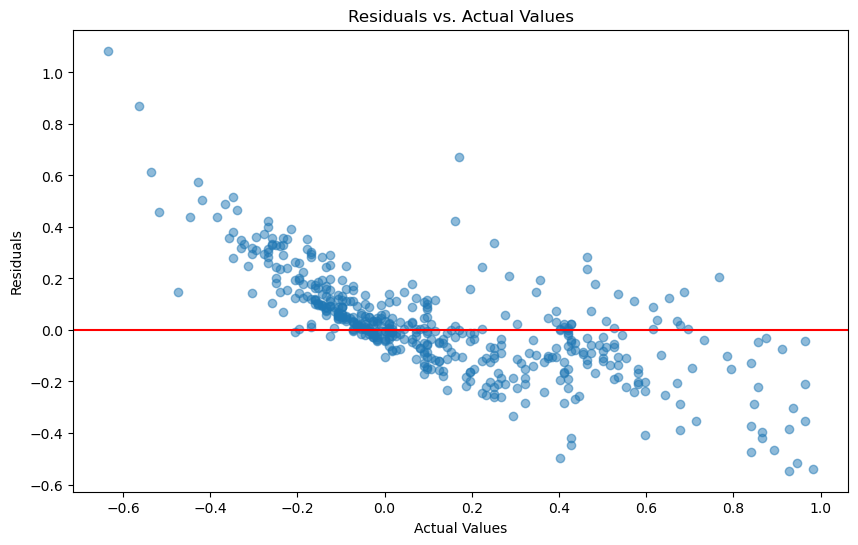

In [47]:
plot_residual_vs_actual(actuals, predictions)

In [48]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇█▆▆▆▅▄▄▃▃▃▃▃▃▃▄▂▂▁▁▁▁
val_mae,▁
val_mse,▁
val_rmse,▁
epoch,25
train_loss,0.04094
val_loss,0.03789
val_mae,0.13865
val_mse,0.03789


### Task 5: Test Data Evaluation

#### Task 5-1 Test Dataset Setup

In [49]:
TEST = 'robo_racer_test'

test_dataset = XYDataset(ROOT_DIR + TEST, TRANSFORMS)

n_samples = len(dataset)

print("Dataset length: ", n_samples)

Dataset length:  1192


In [50]:
# Create Dataloader
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Test Dataset Sample Images:


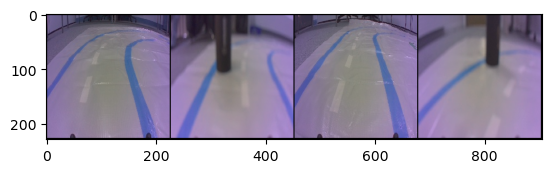

Labels: tensor([[ 0.0179, -0.0714],
        [ 0.2679,  0.1875],
        [ 0.0893, -0.0625],
        [ 0.7054,  0.0536]])


In [51]:
# Print sample images
print("Test Dataset Sample Images:")
show_sample_images(test_dataloader)

#### Task 5-2 Simple CNN test data evaluation

Set model

Process training

In [52]:
wandb.init(project="robo_racer_project", name="Simple_CNN_Test", config={
    "epochs": 25,
    "batch_size": BATCH_SIZE,
    "lr": 1e-3
})

In [53]:
# Define the loss function and optimizer
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# Train the model
train_losses, test_losses = train_and_validate(model, train_dataloader, test_dataloader, criterion, optimizer, config)

Epoch 1/25, Train Loss: 7.9772, Val Loss: 0.0968
Epoch 2/25, Train Loss: 0.0697, Val Loss: 0.0867
Epoch 3/25, Train Loss: 0.0622, Val Loss: 0.0682
Epoch 4/25, Train Loss: 0.0535, Val Loss: 0.0543
Epoch 5/25, Train Loss: 0.0431, Val Loss: 0.0473
Epoch 6/25, Train Loss: 0.0408, Val Loss: 0.0471
Epoch 7/25, Train Loss: 0.0386, Val Loss: 0.0451
Epoch 8/25, Train Loss: 0.0334, Val Loss: 0.0446
Epoch 9/25, Train Loss: 0.0316, Val Loss: 0.0425
Epoch 10/25, Train Loss: 0.0325, Val Loss: 0.0361
Epoch 11/25, Train Loss: 0.0305, Val Loss: 0.0415
Epoch 12/25, Train Loss: 0.0288, Val Loss: 0.0352
Epoch 13/25, Train Loss: 0.0274, Val Loss: 0.0349
Epoch 14/25, Train Loss: 0.0248, Val Loss: 0.0300
Epoch 15/25, Train Loss: 0.0241, Val Loss: 0.0281
Epoch 16/25, Train Loss: 0.0217, Val Loss: 0.0266
Epoch 17/25, Train Loss: 0.0201, Val Loss: 0.0291
Epoch 18/25, Train Loss: 0.0203, Val Loss: 0.0256
Epoch 19/25, Train Loss: 0.0199, Val Loss: 0.0273
Epoch 20/25, Train Loss: 0.0194, Val Loss: 0.0242
Epoch 21/

Summarize history for loss

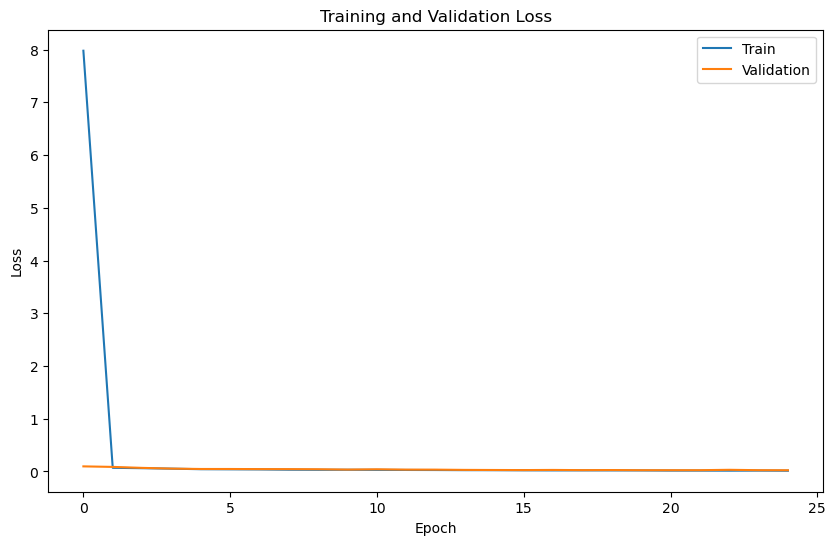

In [54]:
plot_loss_history(train_losses, test_losses)

Evaluate test set

In [55]:
evaluation_metrics = evaluate_model(model, test_dataloader, criterion)

Validation Loss: 0.0237, Validation MSE: 0.0237, Validation RMSE: 0.1541, Validation MAE: 0.1093


Visualize the result

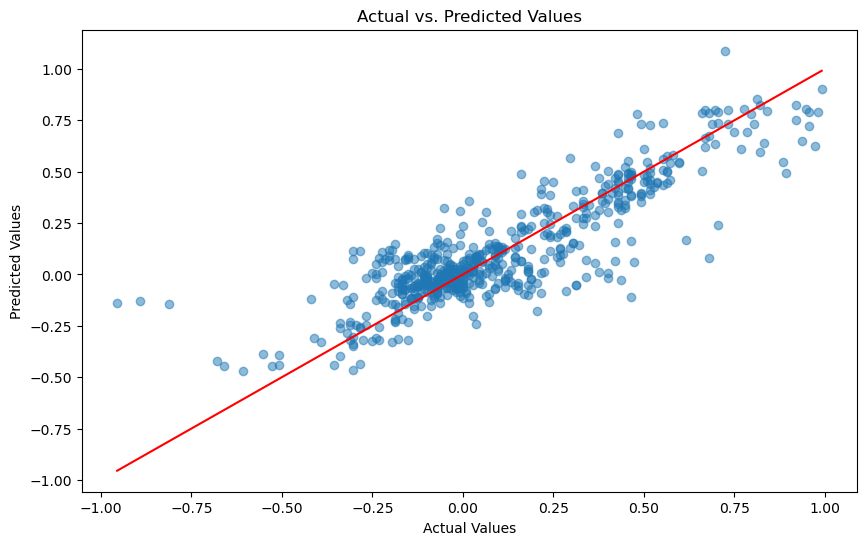

In [56]:
actuals = evaluation_metrics["actuals"]
predictions = evaluation_metrics["predictions"]
plot_actual_vs_predicted(actuals, predictions)

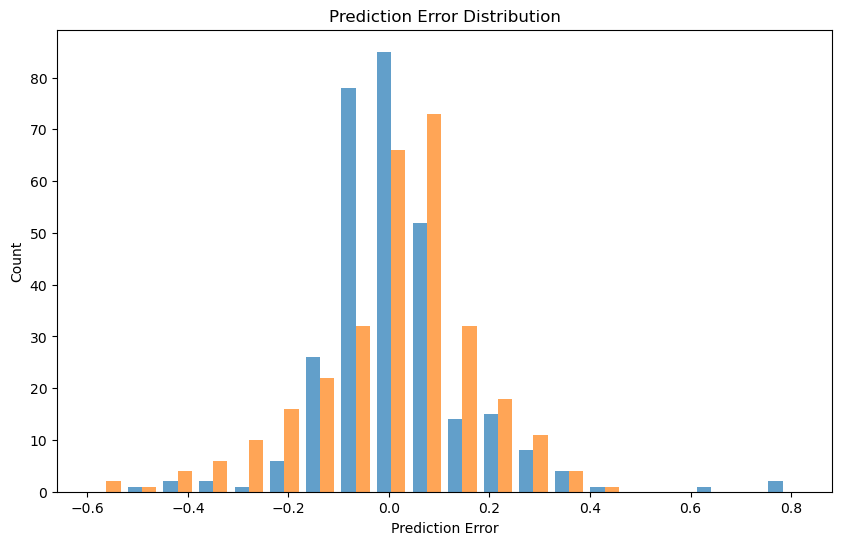

In [57]:
plot_error_distribution(actuals, predictions)

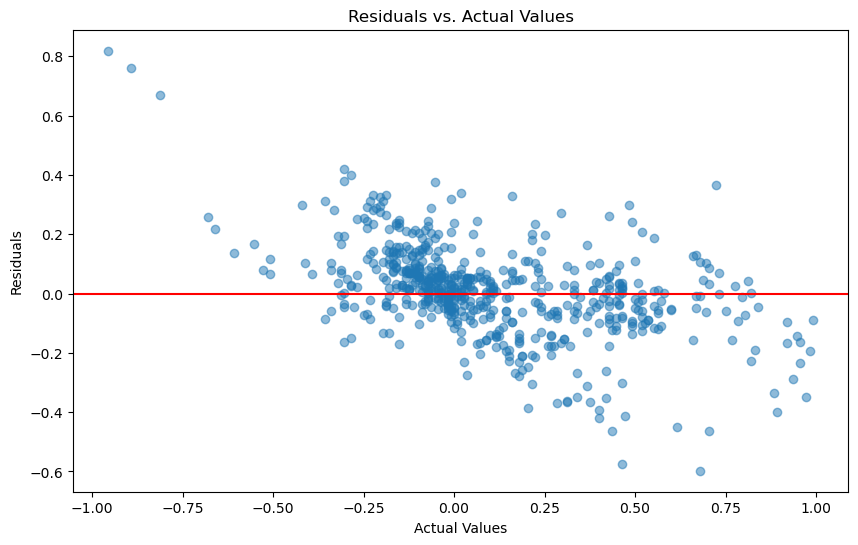

In [58]:
plot_residual_vs_actual(actuals, predictions)

In [59]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▃▃▂▃▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁
val_mae,▁
val_mse,▁
val_rmse,▁
epoch,25
train_loss,0.01438
val_loss,0.02374
val_mae,0.10928
val_mse,0.02374


#### Task 5-3 Transfer CNN test data evaluation

Process training

In [60]:
wandb.init(project="robo_racer_project", name="Transfer_CNN_Test", config={
    "epochs": 25,
    "batch_size": BATCH_SIZE,
    "lr": 1e-3
})

In [61]:
# Define the loss function and optimizer
model = TransferCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# Train the model
train_losses, test_losses = train_and_validate(model, train_dataloader, test_dataloader, criterion, optimizer, config)

C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25, Train Loss: 0.1696, Val Loss: 0.1245
Epoch 2/25, Train Loss: 0.0996, Val Loss: 0.0974
Epoch 3/25, Train Loss: 0.0868, Val Loss: 0.1076
Epoch 4/25, Train Loss: 0.0715, Val Loss: 0.0781
Epoch 5/25, Train Loss: 0.0616, Val Loss: 0.0700
Epoch 6/25, Train Loss: 0.0587, Val Loss: 0.0712
Epoch 7/25, Train Loss: 0.0531, Val Loss: 0.0617
Epoch 8/25, Train Loss: 0.0474, Val Loss: 0.0613
Epoch 9/25, Train Loss: 0.0492, Val Loss: 0.0783
Epoch 10/25, Train Loss: 0.0436, Val Loss: 0.0539
Epoch 11/25, Train Loss: 0.0407, Val Loss: 0.0579
Epoch 12/25, Train Loss: 0.0386, Val Loss: 0.0572
Epoch 13/25, Train Loss: 0.0415, Val Loss: 0.0652
Epoch 14/25, Train Loss: 0.0406, Val Loss: 0.0499
Epoch 15/25, Train Loss: 0.0385, Val Loss: 0.0647
Epoch 16/25, Train Loss: 0.0355, Val Loss: 0.0527
Epoch 17/25, Train Loss: 0.0332, Val Loss: 0.0474
Epoch 18/25, Train Loss: 0.0333, Val Loss: 0.0472
Epoch 19/25, Train Loss: 0.0302, Val Loss: 0.0465
Epoch 20/25, Train Loss: 0.0340, Val Loss: 0.0493
Epoch 21/

Summarize history for loss

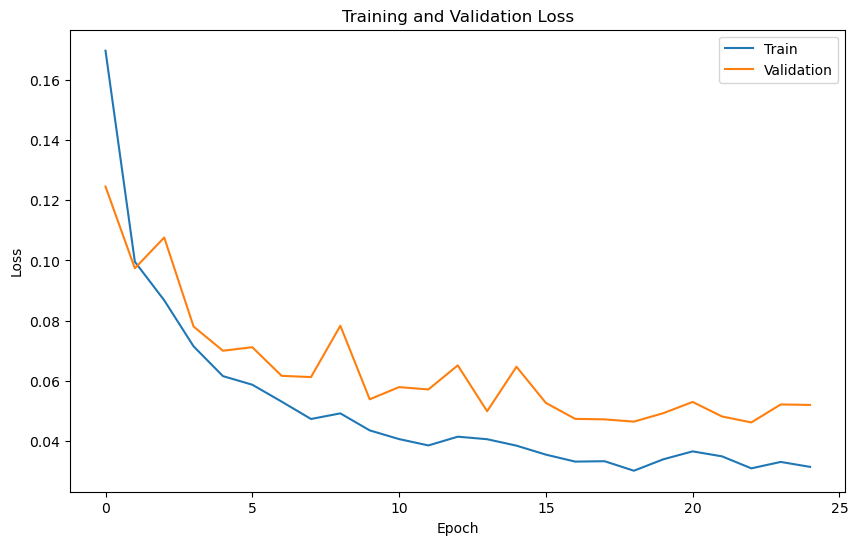

In [62]:
plot_loss_history(train_losses, test_losses)

Evaluate test set

In [63]:
evaluation_metrics = evaluate_model(model, test_dataloader, criterion)

Validation Loss: 0.0520, Validation MSE: 0.0520, Validation RMSE: 0.2281, Validation MAE: 0.1720


Visualize the result

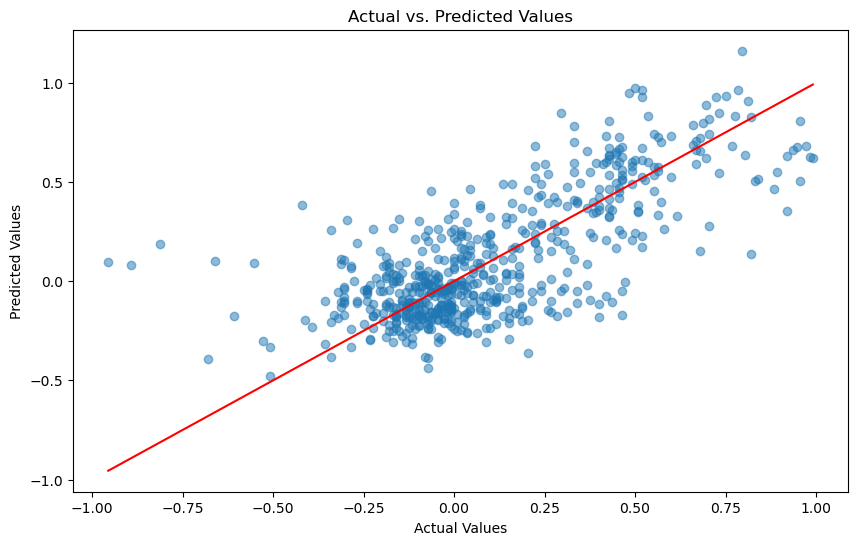

In [64]:
actuals = evaluation_metrics["actuals"]
predictions = evaluation_metrics["predictions"]
plot_actual_vs_predicted(actuals, predictions)

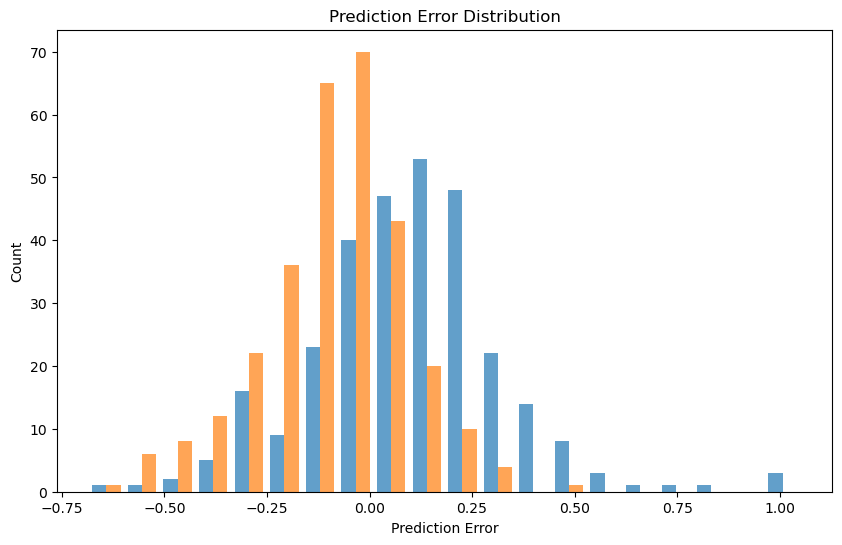

In [65]:
plot_error_distribution(actuals, predictions)

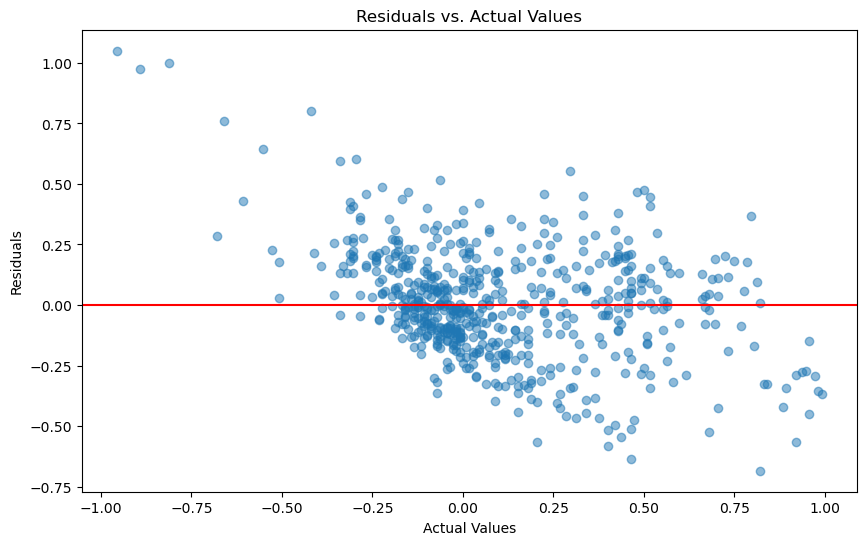

In [66]:
plot_residual_vs_actual(actuals, predictions)

In [67]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▄▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▃▃▂▂▄▂▂▂▃▁▃▂▁▁▁▁▂▁▁▂▂▂
val_mae,▁
val_mse,▁
val_rmse,▁
epoch,25
train_loss,0.03145
val_loss,0.05202
val_mae,0.17197
val_mse,0.05202


#### Task 5-4 Simple CNN with augmentation test data evaluation

Process training

In [68]:
wandb.init(project="robo_racer_project", name="Simple_CNN_Test", config={
    "epochs": 25,
    "batch_size": BATCH_SIZE,
    "lr": 1e-3
})

In [69]:
# Define the loss function and optimizer
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

# Train the model
train_losses, test_losses = train_and_validate(model, train_dataloader_aug, test_dataloader, criterion, optimizer, config)

Epoch 1/25, Train Loss: 1.7634, Val Loss: 0.0802
Epoch 2/25, Train Loss: 0.0714, Val Loss: 0.0825
Epoch 3/25, Train Loss: 0.0708, Val Loss: 0.0777
Epoch 4/25, Train Loss: 0.0691, Val Loss: 0.0740
Epoch 5/25, Train Loss: 0.0654, Val Loss: 0.0823
Epoch 6/25, Train Loss: 0.0601, Val Loss: 0.0674
Epoch 7/25, Train Loss: 0.0582, Val Loss: 0.0663
Epoch 8/25, Train Loss: 0.0590, Val Loss: 0.0632
Epoch 9/25, Train Loss: 0.0558, Val Loss: 0.0656
Epoch 10/25, Train Loss: 0.0527, Val Loss: 0.0601
Epoch 11/25, Train Loss: 0.0542, Val Loss: 0.0655
Epoch 12/25, Train Loss: 0.0534, Val Loss: 0.0571
Epoch 13/25, Train Loss: 0.0521, Val Loss: 0.0577
Epoch 14/25, Train Loss: 0.0473, Val Loss: 0.0518
Epoch 15/25, Train Loss: 0.0504, Val Loss: 0.0519
Epoch 16/25, Train Loss: 0.0491, Val Loss: 0.0490
Epoch 17/25, Train Loss: 0.0465, Val Loss: 0.0587
Epoch 18/25, Train Loss: 0.0437, Val Loss: 0.0484
Epoch 19/25, Train Loss: 0.0444, Val Loss: 0.0473
Epoch 20/25, Train Loss: 0.0450, Val Loss: 0.0500
Epoch 21/

Summarize history for loss

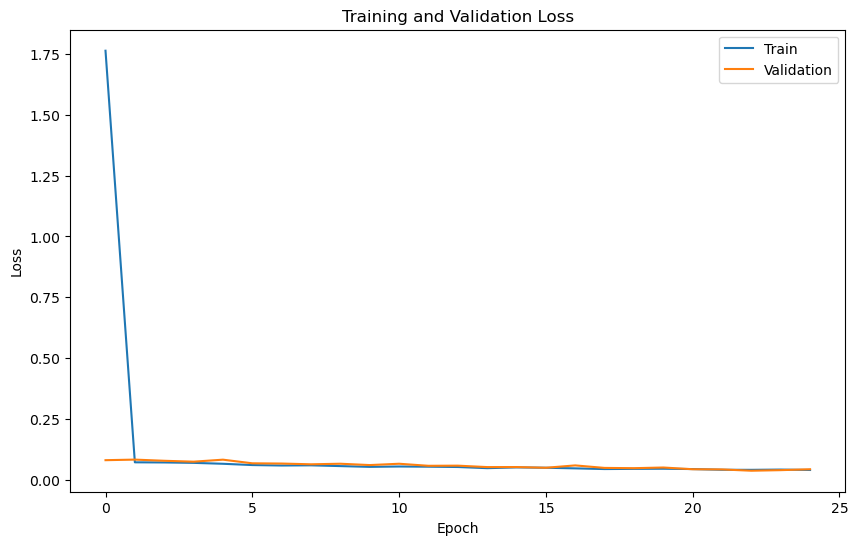

In [70]:
plot_loss_history(train_losses, test_losses)

Evaluate test set

In [71]:
evaluation_metrics = evaluate_model(model, test_dataloader, criterion)

Validation Loss: 0.0429, Validation MSE: 0.0429, Validation RMSE: 0.2071, Validation MAE: 0.1398


Visualize the result

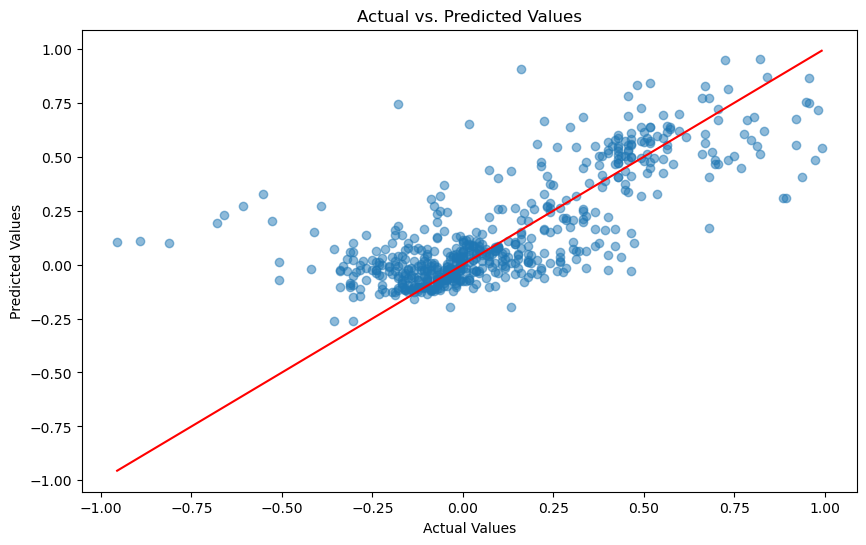

In [72]:
actuals = evaluation_metrics["actuals"]
predictions = evaluation_metrics["predictions"]
plot_actual_vs_predicted(actuals, predictions)

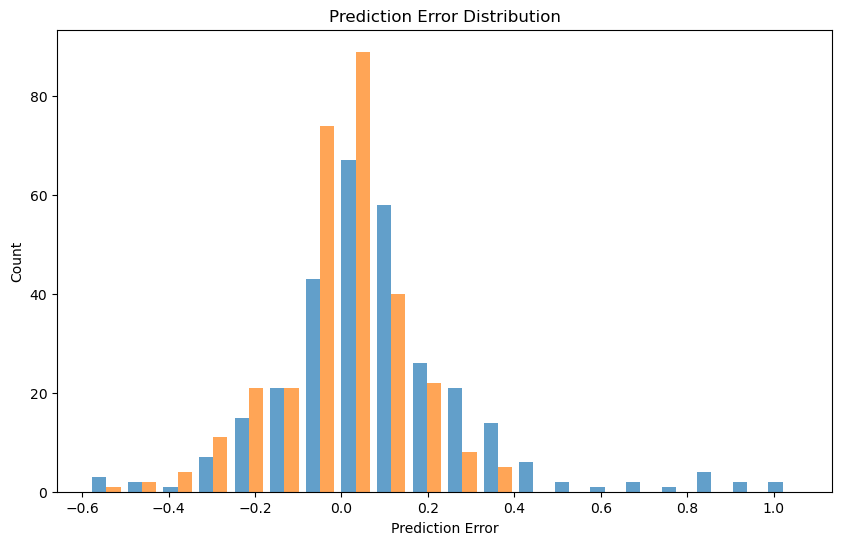

In [73]:
plot_error_distribution(actuals, predictions)

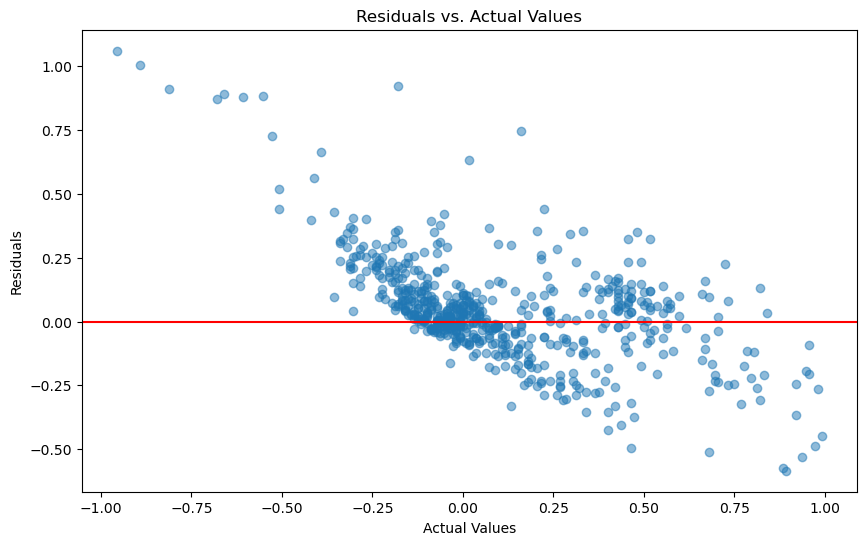

In [74]:
plot_residual_vs_actual(actuals, predictions)

In [75]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇█▆▆▅▅▅▅▄▄▃▃▃▄▃▃▃▂▂▁▁▂▂
val_mae,▁
val_mse,▁
val_rmse,▁
epoch,25
train_loss,0.0399
val_loss,0.04288
val_mae,0.13975
val_mse,0.04288


### Task 6: Reflection

| Model | Set | MSE | RMSE | MAE |
|:------|:----|:----|:-----|:----|
| Simple CNN | Train/Val | 0.0238 | 0.1542 | 0.1107 |
| Transfer CNN | Train/Val | 0.0378 | 0.1944 | 0.1497 |
| Simple CNN with Augmentation | Train/Val | 0.0379 | 0.1946 | 0.1387 |
| Simple CNN | Train/Test | 0.0237 | 0.1541 | 0.1093 |
| Transfer CNN | Train/Test | 0.0520 | 0.2281 | 0.1720 |
| Simple CNN with Augmentation | Train/Test | 0.0429 | 0.2071 | 01398 |


Overall, I solved this tasks by implementing regression model because regression model is sutible for continuous values. The results show that simiple CNN model without trasfer learning has the best model for this tasks. This performance could be influenced by the overfitting because simple CNN with data Augmentation has lower performance which is similar score with the transfer CNN. However, according to the result of the evaluation with test set, both simple CNN's performances were similar and even a little better than the result with validation dataset, while the other model (Transfer CNN Model) has some gap between the results of the model with validation dataset and test dataset. This means simple CNN model is generalized well The gap between Transfer CNN with validation dataset and test dataset was the biggest gap.
Transfer CNN demonstrates higher error rates across all metrics compared to the simple CNN. This result means that transfer learning effected to a specific task, or it's not generalized because of the overfitting. For the further analysis, more careful tuning can be involved to avoid negative transfer.
In terms of the simple CNN with data augmentation, virtical flip could not be suitable for real life examples, but I've used it for exercise.
Further experiments might involve hyperparameter tuning, different augmentation techniques for optimal performance.
The most difficult situation I've encountered was when I reused the model class. I put the model declaration after the optimizer declaration, and this caused unexpected result without error message. I couldn't figure out the cause of this semantic error for a while.